# STROOPWAFEL code (based on toy model output) 

**A jupyter notebook that contains the STROOPWAFEL algorithm and a toy model with some tests and examples of the code** 

based on the paper https://arxiv.org/pdf/1905.00910.pdf  (from now on referred to as FSB+2019) <br>

Last updated by: Floor Broekgaarden 29 Nov 2019




In [1]:
import math
import numpy as np
import scipy
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.stats import multivariate_normal
from scipy import integrate
from scipy import stats
import random
from scipy.integrate import quad

# display jupyter notebook
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# set font & plot tick sizaes
from matplotlib import rc
from matplotlib import rcParams
rc('font', family='serif', weight='bold')
rc('axes', linewidth=2)
matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.size'] = 8
fs = 24 # fontsize for plot
matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
matplotlib.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


In [2]:
class priors(object):
    """class with priors pi(x) used in binary population synthesis
    Eq. 1 in FSB+2019 """

    def prior_m1(m1, self):
        """returns prior probability of the primary star initial mass: m1
        based on Kroupa+2001"""
        norm_const = (-self.alpha_IMF + 1) / \
        (self.max_m1**(-self.alpha_IMF+1) - self.min_m1**(-self.alpha_IMF + 1))
        p_m1 = norm_const * m1**(-self.alpha_IMF)
        return p_m1

    def prior_loga(loga, self):
        """returns prior probability of the separation log_10(a):
         based on Sana+2012"""
        p_loga = 1./(self.max_loga-self.min_loga)
        return p_loga

    def prior_a(a, self):
        """returns prior probability of the separation a
        based on Sana+2012"""
        p_a = (1./(a*np.log(10.)))*(1./(self.max_loga-self.min_loga))
        return p_a

    def prior_q(q, self):
        """returns prior probability of the mass ratio q
        based on Opik 1924, Abt+1983"""
        p_q = 1./(self.max_q-self.min_q)
        return p_q


class toymodel(object):
    """class with all the functions belonging to the toy model
    of 3 boxes as described in Appendix B of FSB+2019"""

    def __init__(self, modelname='m0', param_ranges=[[5, 100], [-1, 3], [0, 1]], alpha_IMF=2.3):
        self.modelname = modelname  # name of the model used, options: m0, m1, m2
        self.dimensions = len(param_ranges)  # nr of dimensions
        # the min and max value of the parameter space of m1, log(a) and q:
        self.param_ranges = param_ranges  # default value param_ranges=[[5,100], [-1,3], [0,1]]
        [[self.min_m1, self.max_m1], [self.min_loga, self.max_loga], [self.min_q, self.max_q]] = param_ranges
        # not log values of a:
        self.min_a, self.max_a = np.log10(self.min_loga), np.log10(self.max_loga)
        self.alpha_IMF = alpha_IMF  # slope of the initial mass function in prior_m1

    def islands(self):
        """defines the location of the center of the toy model boxes
        and the radial extension in each individual parameter direction"""

        # m0 gives a fractional volume ~0.001
        if self.modelname == 'm0':
            # centers of [m1, a, q] of the toymodel islands
            centers1, centers2, centers3 = [20, 34.0, 0.3], [40, 1.0, 0.3], [34, 7, 0.8]
            # radial extension in [m1, a, q] direction of the toymodel islands
            radii1, radii2, radii3 = [1.9, 8.0, 0.1], [1.7, 0.6, 0.2], [1.8, 0.6, 0.1]

        # m1 gives a fractional volume ~0.0001
        elif self.modelname == 'm1':
            # centers of [m1, a, q] of the toymodel islands
            centers1, centers2, centers3 = [20, 34.0, 0.3], [40, 1.0, 0.3], [34, 7, 0.8]
            # radial extension in [m1, a, q] direction of the toymodel islands
            radii1, radii2, radii3 = [0.9, 0.9, 0.2], [0.3, 0.65, 0.1], [0.6, 0.5, 0.04]

        # m1 gives a fractional volume ~0.01
        elif self.modelname == 'm2':
            # centers of [m1, a, q] of the toymodel islands
            centers1, centers2, centers3 = [20, 34.0, 0.3], [40, 1.0, 0.3], [34, 7, 0.8]
            # radial extension in [m1, a, q] direction of the toymodel islands
            radii1, radii2, radii3 = [8.5, 7.0, 0.2], [7, 0.85, 0.27], [3.6, 2, 0.15]
        else:
            print("Error: unknown toy model name, input given: modelname =", self.modelname)

        # combine & return toy model parameters
        toymodel_centers = [centers1, centers2, centers3]
        toymodel_radii = [radii1, radii2, radii3]

        return toymodel_centers, toymodel_radii

    def output(self, samples):
        '''returns mask for samples with 0 if sample lies not within one of the toy model boxes
        and 1 if sample lies within toy model boxes "a hit"
        samples have to be in the form of [m1, a, q]
        this is Eq. B1 in FSB+2019 or  phi(x_i) in Eq. 4'''

        toymodel_centers, toymodel_radii = toymodel.islands(self)

        mask_hits = np.zeros_like(samples[0])  # temp placeholder for hits mask

        # loop over toy model boxes ("islands")
        for ind_island in range(len(toymodel_centers)):
            # loop over each parameter dimension
            mask_hits_island = np.ones_like(samples[0])
            for dim in range(self.dimensions):
                # use the abs distance of each sample from the sphere centers in each dimension
                # to determine if sample lies inside toy model sphere
                dist_sample = abs(np.asarray(samples[dim]) - toymodel_centers[ind_island][dim])
                mask_hits_island *= (dist_sample < toymodel_radii[ind_island][dim])
            # add new hits to mask, hits are a 1:
            mask_hits = (mask_hits == 1) | (mask_hits_island == 1)

        return mask_hits

    def analyticalVolume(self):
        """Calculates analytically the prior weighted Volume of the toy model island
        output:
        fraction_analytic: combined fractional rate (i.e. prior weighted volume) of the toy model islands
        this is V_D in FSB+2019 (see appendix B)
        /.
        """
        # centers and radii of toy model sphere in each direction:
        toymodel_centers, toymodel_radii = toymodel.islands(self)

        priorlist = [priors.prior_m1, priors.prior_a, priors.prior_q]

        # calculate analytically the prior weighted volume of toy islands
        fraction_analytic = 0
        # loop over toy model islands
        for ind_island in range(len(toymodel_centers)):
            # loop over dimensions [m1,a,q]
            fraction_ind = 1  # set to 1
            for dim in range(self.dimensions):
                # each island's volume is givem by int p(m1) dm1 * int p(a) da * int p(q) dq,
                # integrated between  center +/- each radii of the dimension.
                int_min = toymodel_centers[ind_island][dim]-toymodel_radii[ind_island][dim]
                int_max = toymodel_centers[ind_island][dim]+toymodel_radii[ind_island][dim]
                fraction_ind *= integrate.quad(priorlist[dim], int_min, int_max, args=(self,))[0]

            # add to combined fraction
            fraction_analytic += fraction_ind

        return fraction_analytic


class sampling(object):
    """class with functions to draw random samples from distributions"""

    def __init__(self, Nsamples=1000, param_ranges=[[5, 100], [-1, 3], [0, 1]], alpha_IMF=2.3):
        self.Nsamples = Nsamples  # total nr of samples
        # parameter range boundaries
        [[self.min_m1, self.max_m1], [self.min_loga, self.max_loga], [self.min_q, self.max_q]] = param_ranges
        self.alpha_IMF = alpha_IMF  # initial mass function slope, default is -2.3 (Kroupa+2001)

    def sampling_m1(self):
        '''returns  Nsamples samples drawn
        from the Kroupa IMF using inverse sampling'''
        samples = ((np.random.uniform(0, 1, self.Nsamples)) *\
            (self.max_m1**(1.-self.alpha_IMF) - self.min_m1**(1.-self.alpha_IMF)) \
            + self.min_m1**(1-self.alpha_IMF))**(1./(1.-self.alpha_IMF))
        return samples

    def sampling_a(self):
        '''returns  Nsamples samples drawn from
        log uniform using inverse sampling'''
        return 10**np.random.uniform(self.min_loga, self.max_loga, self.Nsamples)

    def sampling_q(self):
        '''returns  Nsamples samples drawn from uniform distribution'''
        return np.random.uniform(self.min_q, self.max_q, self.Nsamples)

    def sampling_MC(self, modelname='m0'):
        """draws Nsamples using birth distribution Monte Carlo and evaluates them
        this is the Traditional sampling in FSB+2019
        returns samples, weights and output (mask_hits) of the samples"""

        # draw samples in each dimension
        samples_MC = [self.sampling_m1(), self.sampling_a(), self.sampling_q()]

        # evaluate samples using toy model
        TM = toymodel(modelname, param_ranges)
        mask_hits_MC = TM.output(samples_MC)

        # the weights are all 1 as we sample from the birth distributions
        weights_MC = np.ones(self.Nsamples)

        return samples_MC, mask_hits_MC, weights_MC



In [3]:
def plotSamples(samples_MC, mask_hits_MC, samples_SW, mask_hits_SW):
    """plots the drawn samples and hits for traditional and stroopwafel sampling
    this is Fig. B1 of FSB+2019
    input:
        samples_MC, mask_hits_MC = samples and output of traditionally Monte Carlo sampling
        samples_SW, mask_hits_SW = samples and output of STROOPWAFEL sampling
    """

    f, (ax2, ax3, cax) = plt.subplots(ncols=3, figsize=(16, 7),\
        gridspec_kw={"width_ratios": [1.5, 1.5, 0.08]})

    nbins = 100  # nr of bins 2dhist
    fs = 24  # fontsize labels

    samples_m1_MC, samples_a_MC, _ = samples_MC
    samples_m1_SW, samples_a_SW, _ = samples_SW

    CMAX = len(samples_m1_MC)  # max range of hist2d

    # plot Monte Carlo samples and hits
    ax2.hist2d(samples_m1_MC, np.log10(samples_a_MC), bins=nbins, \
        cmap='binary', norm=matplotlib.colors.LogNorm(), cmin=0, cmax=CMAX)
    sc = ax2.hist2d(samples_m1_MC, np.log10(samples_a_MC), bins=nbins, \
        cmap='gray_r', norm=matplotlib.colors.LogNorm(), cmin=0, cmax=CMAX)
    ax2.scatter(samples_m1_MC[mask_hits_MC], np.log10(samples_a_MC[mask_hits_MC]), \
        c='lime', s=fs-5, edgecolor='', label='hits', zorder=10)

    # plot only if Stroopwafel samples are given
    if len(mask_hits_SW):
        # plot stroopwafel samples and hits
        ax3.hist2d(samples_m1_SW, np.log10(samples_a_SW), bins=nbins, \
            cmap='binary', norm=matplotlib.colors.LogNorm(), cmin=0, cmax=CMAX)
        sc = ax3.hist2d(samples_m1_SW, np.log10(samples_a_SW), bins=nbins, \
                cmap='gray_r', norm=matplotlib.colors.LogNorm(), cmin=0, cmax=CMAX)
        ax3.scatter(samples_m1_SW[mask_hits_SW], np.log10(samples_a_SW[mask_hits_SW]),\
            c='lime', s=fs - 5, edgecolor='', zorder=10)

    # plot labels
    ax2.set_xlabel(r' $m_1$', fontsize=fs)
    ax2.set_ylabel(r' $\log a$', fontsize=fs)
    ax2.set_title('Monte Carlo sampled', fontsize=fs)
    ax2.legend(fontsize=fs)

    ax3.set_xlabel(r'$m_1$ ', fontsize=fs)
    ax3.set_ylabel(r'$\log a$', fontsize=fs)
    ax3.set_title('STROOPWAFEL sampled', fontsize=fs)

    # colorbar for sampling density
    cbar = plt.colorbar(sc[3], cax, orientation='vertical')
    cbar.set_label('Number of samples', fontsize=fs)
    cax.tick_params(labelsize=fs)

    ax2.tick_params(labelsize=fs)
    ax3.tick_params(labelsize=fs)

    plt.tight_layout()

    plt.show()


<div class="alert alert-block alert-info"> 
Below we will first look at an example of traditionally sampling using birth distribution Monte Carlo sampling.  <br>
In this scenario we sample random binaries from the birth distributions.     <br>

We sample in this example **Nsamples** = 100000 binaries, evaluate the samples through our toy model output which will return a hit (1) if the drawn sample lies in one of the toy model spheres 
and a miss (0) if the sample does not lie in one of the toy model spheres. These outcomes are saved in **mask_hits_MC**. 

We plot a 2D histogram of all samples that we have drawn (where the darker the histogram cell, the more samples are drawn in that region), and overplot with scatterpoints the samples that evaluated as a hit <br>
the 2D histogram thus represents where most of our computational time is spend, whereas the green scatter points show where out region of interest (i.e. hits/ target population) lies in the parameter space. <br>

The plot below is a 2D slice in m1 and log(a) of the 3dimensional parameter space m1, log(a) and q where stroopwafel is used in. 




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10


Analytically determined fractional rate =  0.0009296344893959073

Monte Carlo fractional rate estimate =  0.001 +/- 0.0001



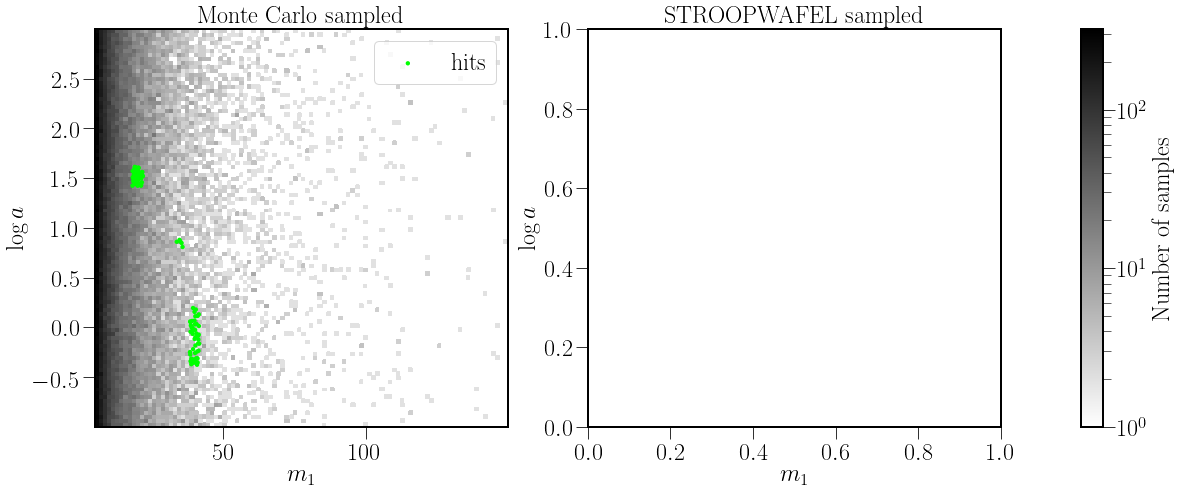

In [4]:
# define the parameter range of m1, log(a) and q:
# (see Appendix C of FSB+2019 for the values)
# param_ranges = [[min_m1, max_m1] in  [Msun],[min_loga, max_loga] in [AU], [min_q, max_q]]
param_ranges = [[5, 150], [-1, 3], [0, 1]]
alpha_IMF = 2.3  # kroupa+2001 IMF power law slope value

# obtain the toy model settings for toymodel "m0"
# (such as the location of the toy model spheres)
# other options are e.g. modelname = "m1" and "m2"
TM = toymodel(modelname="m0",  param_ranges=param_ranges)

# calculate analytically what the fractional volume of the toy model spheres is:
# in practise we don't know on beforehand what this volume is.
fraction_analytic = TM.analyticalVolume()
print('Analytically determined fractional rate = ', fraction_analytic)

print()
# now run a Traditional Monte Carlo experiment to estimate this rate:
SAMPLING = sampling(Nsamples=100000, param_ranges=param_ranges, alpha_IMF=alpha_IMF)
samples_MC, mask_hits_MC, weights_MC = SAMPLING.sampling_MC(modelname='m0')
MonteCarlo_rate_est = np.sum(weights_MC[mask_hits_MC]) / len(samples_MC[0])
# MonteCarlo_unce_est =
print('Monte Carlo fractional rate estimate = ', MonteCarlo_rate_est, '+/-', \
    np.round(np.sqrt(np.sum(weights_MC[mask_hits_MC])) / len(samples_MC[0]), 6))
print()

# plot the samples and hits of the Monte Carlo sampled simulation
plotSamples(samples_MC=samples_MC, mask_hits_MC=mask_hits_MC, samples_SW=[[], [], []], mask_hits_SW=[])



<div class="alert alert-block alert-info"> 
The green rectangles above are the 3 toy model islands that the Traditional Monte Carlo sampling has encovered. <br>
However, it can be clearly seen that those rectangles are not fully recoverd. Moreover, most of our samples, and hence computational time, 
has been spend on samples with low m1 values (dark vertical region on far left), whereas our 'hits' lie much more to the right of this region. <br>
It is clear that we have spend most of our computational time on evaluating samples that are 'misses'. This is mostly because the birth distributions where we sampled from <br>
like the initial mass function, are very dissimilar to where the hits lie. <br>
    
STROOPWAFEL sampling tries to overcome this by adapting the location of new drawn samples to where the hits are found. Just like how most people play the game Battleships where you first explore your parameter space
until you have found a few hits and you start refining your search by instead looking around your previously found hits 

In [5]:
class stroopwafel(object):
    """class with all the stroopwafel functions"""

    def __init__(self, modelname='m0', Nsamples=1000, param_ranges=[[5, 100], [-1, 3], [0, 1]], alpha_IMF=2.3):
        self.modelname = modelname  # name of the model used, options: m0, m1, m2
        self.dimensions = len(param_ranges)  # nr of dimensions
        # the min and max value of the parameter space of m1, log(a) and q:
        self.param_ranges = param_ranges
        # default value param_ranges=[[5, 100], [-1, 3], [0, 1]]
        [[self.min_m1, self.max_m1], [self.min_loga, self.max_loga], [self.min_q, self.max_q]] = param_ranges
        self.alpha_IMF = alpha_IMF  # slope of the initial mass function in prior_m1
        self.Nsamples = Nsamples  # number of total samples used
        self.fexpl = 1  # fraction of samples spend on exploration phase (self consistently calculated)
        self.NBatchesUsed = 1  # number of parallel batched used, default=1 (more is not yet fully implemented)
        self.Nexpl = 0  # number of samples in exploratory phase (self consistently calculated)
        self.Nref = 0  # number of samples in refinement phase  (self consistently calculated)
        self.Nexpl_hits = 0  # number of hits in the exploratory phase (self consistently calculated)
        # Normalization constant initial mass function:
        self.K1 = (-self.alpha_IMF + 1) / (self.max_m1**(-self.alpha_IMF + 1) - self.min_m1**(-self.alpha_IMF + 1))

    def calculateFractionExploration(self, rate):
        """ calculates the fraction of samples from the exploration phase
        see also eq. 18 in FSB+2019"""

        z2 = 1. / self.Nsamples  # since fexpl
        z1 = rate - z2

        numerator = z1 * (np.sqrt(1. - z1) - np.sqrt(z2))
        denominator = (np.sqrt(1 - z1) * (np.sqrt(z2 * (1. - z1)) + z1))

        # fexpl = 1 - fref (Eq. 18)
        # where fref = fraction of samples spend on refinement phase
        fref = numerator / denominator

        return 1 - fref

    def calculatesPi(self, samples=[20, 0, 0.5]):
        ''' returns the probability for each of the samples based on the priors
        see Eq. 1 of FSB+2019 (https://arxiv.org/pdf/1905.00910.pdf)
        input:
            samples = [m1, loga, q], array of samples
        '''

        # pdf contribution from prior sampling
        priorm1 = priors.prior_m1(samples[0], self)
        priora = priors.prior_loga(samples[1], self)
        priorq = priors.prior_q(samples[2], self)

        # assuming independent priors
        piPDF = priorm1 * priora * priorq

        return piPDF

    def calculatessmallq(self, mu=[20, 0, 0.5], Sigma=[10, 0.2, 0.01], samples=[20, 0, 0.5]):
        '''function that calculates the pdf of the instrumental distribution
        it returns the probability for each of the samples for the mixture pdf
        this is Equation 8 (q(x)) of FSB+2019
        input:
            mu = array with means of Gaussians in m1,log(a),q space (which are the location of the hits)
            Sigma = array with variances of each gaussian in m1,log(a),q space (sigma^2, with sigma from Eq. 11)
            samples = array of samples in m1, log(a), q space
        '''

        # make a matrix which we will fill up with contributions to the PDF from each Gaussian
        xPDF = np.zeros((self.Nexpl_hits, len(samples[0])))

        # calculate for each gaussian the probability of drawing the samples from that gaussian \
        for i in range(self.Nexpl_hits):
            # 3D gaussian variance
            var = [[Sigma[0][i], 0, 0], [0, Sigma[1][i], 0], [0, 0, Sigma[2][i]]]
            # probability of 3d i-th gaussian with given mean and variance
            xPDF[i, :] = (multivariate_normal.pdf(np.transpose(samples), np.transpose(mu)[i], var))

        # sum all the probabilities from each gaussian together and normalize
        qPDF = np.sum(xPDF, axis=0) * (float(self.Nexpl_hits))**-1  # Eq. 8 of FSB+2019

        return qPDF

    def inverse_m1(self, m1):
        """inverse cdf of initial mass function
        used to map m1 samples to [0,1] (instead of [min_m1, max_m1])
        used for calculating pi_j(x_k) in Eq. 11 of FSB+2019"""

        m1_inverse = (((self.K1 / m1)**(1 / self.alpha_IMF)) - ((self.K1 / self.min_m1)**(1 / self.alpha_IMF))) / \
            (((self.K1 / self.max_m1)**(1 / self.alpha_IMF)) - ((self.K1 / self.min_m1)**(1 / self.alpha_IMF)))
        return m1_inverse

    def inverseback_m1(self, m1_inverse):
        """transforms inverse cdf of initial mass function back to [min_m1, max_m1] range
        used for calculating pi_j(x_k) in Eq. 11 of FSB+2019"""
        m1 = self.K1 / (((m1_inverse * (((self.K1/self.max_m1)**(1 / self.alpha_IMF)) -\
            ((self.K1 / self.min_m1)**(1 / self.alpha_IMF)))) + ((self.K1 / self.min_m1)**(1 / self.alpha_IMF)))**(self.alpha_IMF))
        return m1

    def calculateFractionRejectedGaussians(self, mu, Sigma):
        """calculates the fraction of samples rejected from the mixture distribution
        Frej (see Eq. 9 in FSB+2019) by doing a Monte Carlo estimate
        """

        # place holder count for nr of rejected samples
        sums_rejected = 0
        # samples per Gaussian that we draw
        NperGauss = 10000

        # sample from each Gaussian NperGauss samples at the same time
        # and combine all samples from all gaussians in sample_{var}
        for i in range(self.Nexpl_hits):

            # sample NperGauss samples from i-th Gaussian for M_1, a and q
            samples_m1 = (multivariate_normal.rvs(mean=mu[0][i], cov=Sigma[0][i], size=NperGauss))
            samples_a = 10**(multivariate_normal.rvs(mean=mu[1][i], cov=Sigma[1][i], size=NperGauss))
            samples_q = multivariate_normal.rvs(mean=mu[2][i], cov=Sigma[2][i], size=NperGauss)

            # mask samples that are inside parameter space
            mask = ((samples_m1 > self.min_m1) & (samples_m1 < self.max_m1)) \
                & ((samples_a > (10.**self.min_loga)) & (samples_a < (10.**self.max_loga))) \
                & ((samples_q > self.min_q) & (samples_q < self.max_q))

            # find nr of rejected samples by counting samples where mask==0
            sum_rejected = len(mask) - np.sum(mask)
            sums_rejected += sum_rejected

        # total samples used in Monte Carlo experiment
        Ntotaldrawn = NperGauss * len(mu[0])
        # fraction of samples that were outside & rejected
        fraction_rejected = sums_rejected / (Ntotaldrawn)

        return fraction_rejected

    def updateFractionExploration(self, counthits=0, i=1):
        """
        Function that updates the fraction that should be spend on the exploratory phase; fexpl
        this is Eq. 16 in FSB+19
        estimates weight of the unidentified target population region
        uses previously found fexpl to estimate z2
        """
        # this function works also for when using stroopwafel parallel
        if(self.NBatchesUsed > 0):
            z2 = 1.0 / (self.fexpl * self.NBatchesUsed * float(self.Nsamples))  # estimated weight of unidentified region
            z1 = float(counthits) / float(i)  # the estimated rate of the target population region

            numerator = z1 * (np.sqrt(1. - z1) - np.sqrt(z2))  # numerator of eq 16
            denominator = np.sqrt(1. - z1) * (np.sqrt(z2 * (1. - z1)) + z1)  # dominator of Eq 16

            self.fexpl = 1. - (float(numerator) / denominator)
        else:
            print("Error: number of Batches given, ", NBatchesUsed, ", is invalid. NBatchesUsed should be a positive integer")

        return self.fexpl

    def calculateMixtureWeights(self, pi_x, q_x,  PIrej, Frej):
        """calculates weights based on the adaptive mixture distribution,
        based on Eq. 13 (and Eqs. 12 & 9) of FSB+2019
        input:
            pi_x = prior probabilities of samples
            q_x = instrumental probabilities of samples
            PIrej = fraction of rejected samples from priors (default=0)
            Frej = fraction of rejected samples from gaussian mixture
        """

        # normalization factors for pi(x) and q(x) due to rejection sampling
        PInorm = 1. / (1. - PIrej)
        Qnorm = 1. / (1. - Frej)

        numerator = PInorm * pi_x
        denomenator = (self.fexpl * PInorm * pi_x) + ((1.-self.fexpl) * Qnorm * q_x)  # Eq. 12

        mixtureweights = numerator / denomenator  # Eq. 13

        return mixtureweights

    def stroopwafel(self, res_sampling=0.01, kappa=2, printing=True):
        ''' 
        main stroopwafel sampling algorithm:
        (1) exploration phase:
            stroopwafel first samples from the priors until enough
            hits are found, this is when fexpl * Nsamples samples are
            sampled (where fexpl is self-consistently updated)
        (2) adaptation phase:
            stroopwafel construct Gaussian distributions around each
            of the previously found successful events. To create an
            adapted instrumental distribution q(x) from the mixture of
            Gaussian distributions. We scale the width of each Gaussian
            with the local sampling density.
        (3) refinement phase
            We draw the remaining samples from this adapted distribution
            which focuses around the target population.

        input:
            res_sampling: resolution of the sampling. To speed up this code
            we draw several samples at the same time. res_sampling sets this resolution. 
            dN = res_sampling * Nsamples , with dN the samples drawn at the same time
            kappa: free parameter that scales the widths of the Gaussians (kappa=2 in FSB+2019)

        output:
            samples_SW: [m1, a, q], array of stroopwafel samples from the combined exploration and refinement phase
            mask_hits_SW: [0,0,1, ...] array identifying whether sample in samples_SW is a hit (1) or miss (0)
            weights_SW: weights of the stroopwafel samples [m1, a, q].
        '''
        if printing==True:
            print()
            print('---- start stroopwafel ----')

        dNsamples = round(self.Nsamples * res_sampling)  # nr of samples drawn at the same time

        #############################
        ## (1) EXPLORATION PHASE   ##
        #############################

        # set toy model settings
        SAMPLING = sampling(Nsamples=dNsamples, param_ranges=self.param_ranges)
        TM = toymodel(modelname=self.modelname, param_ranges=self.param_ranges)

        # create empty arrays placeholders for all samples and all hits
        samples_expl, samples_expl_hits, mask_expl_hits = [], [], []
        for dim in range(3):
            samples_expl.append(np.asarray([]))
            samples_expl_hits.append(np.asarray([]))

        # see algorithm 1 in FSB+2019
        counthits, i = 0, 0
        while (i/self.Nsamples) < self.fexpl:
            i+=dNsamples
            # draw new samples from priors and evaluate
            # dsamples stores the samples, mask_hits stores the information of hits vs miss 
            dsamples, mask_hits, _ = SAMPLING.sampling_MC(modelname=self.modelname)

            # add nr of hits in dsamples to total count of hits
            counthits+= np.sum(mask_hits)
            # update fexpl
            self.fexpl = self.updateFractionExploration(counthits, i)

            # store samples and hits from exploratory phase
            for dim in range(self.dimensions):
                samples_expl[dim] = np.concatenate((samples_expl[dim], dsamples[dim]))
                samples_expl_hits[dim] = np.concatenate((samples_expl_hits[dim], dsamples[dim][mask_hits]))

            # store the output of the samples (i.e. hit or miss)
            mask_expl_hits = np.concatenate((mask_expl_hits, mask_hits))

        self.Nexpl = i; # nr of samples in exploratory phase
        self.Nexpl_hits = counthits # nr of hits in exploratory phase
        
        if printing==True:
            print('     - finished exploratory phase ')
            print(r'fexpl $\approx$', round(self.fexpl, 2), '|  Nsamples,expl =', self.Nexpl, '| # hits found =', self.Nexpl_hits)
            print()

        # update fexpl, with the actual fraction of samples drawn from expl phase
        self.fexpl = self.Nexpl / self.Nsamples 

        #############################
        ##### ADAPTATION  PHASE #####
        #############################

        # calculate the nr of remaining samples that we want to draw
        self.Nref = self.Nsamples - self.Nexpl

        if self.Nref >= 1:
            # set mean, mu, of gaussians to location hits
            # use log(a) instead of a for this
            samples_expl_hits[1] = np.log10(samples_expl_hits[1])
            mu = samples_expl_hits

            #### Covariances of the Gaussians  #####
            # calculate average density of samples in unit cube per dimension:
            avdist_expl_1d = 1 / (self.Nexpl)**(1/ self.dimensions)  # this is 1 / N_{expl}^{1/d) in Eq. 11

            # Calculate average distance to next hit for m1 (by using above average difference between samples in unit cube [0,1]^3)
            # assumes parameters to be independent
            # use this to calculate cov for m1
            inverse_m1_hits = self.inverse_m1(samples_expl_hits[0]) # invert to unit box (or line in 1D)
            averageDrightm1 = np.abs(self.inverseback_m1(inverse_m1_hits+avdist_expl_1d ) - self.inverseback_m1(inverse_m1_hits)) 
            averageDleftm1 = np.abs(self.inverseback_m1(inverse_m1_hits-avdist_expl_1d ) - self.inverseback_m1(inverse_m1_hits))
            cov_m1 = np.maximum(averageDleftm1, averageDrightm1)   # take the max average distance to a point in the left or right 

            # calculate cov for q
            cov_q = np.ones(self.Nexpl_hits)*(avdist_expl_1d* (self.max_q - self.min_q)) # Since q already uniform on [0,1]
            # calculate cov for  a 
            cov_loga = np.ones(self.Nexpl_hits)*(avdist_expl_1d * (self.max_loga - self.min_loga))

            # the covariances of the gaussians will be a factor np.sqrt(kappa) wider 
            # calculate the variances, var = cov**2
            var_m1 = kappa**2 * np.asarray(cov_m1)**2
            var_loga = kappa**2 * np.asarray(cov_loga)**2
            var_q = kappa**2 * np.asarray(cov_q)**2

            # store variances as Sigma, this is the diagonal of Eq. 10
            Sigma = [var_m1, var_loga, var_q]

            # estimate the fraction of samples that is rejected from mixture distribution
            Frej = self.calculateFractionRejectedGaussians(mu, Sigma)  # Frej in Eq. 9

            if printing==True:
                print('     - finished adaptation phase  ')
                print()              

            #############################
            ##### REFINEMENT  PHASE #####
            #############################              
            
            # draw remaining samples from mixture distribution
            # since some samples will be rejected we will draw (1+Frej*120) more than needed
            # we will then draw to many and later cut to the Nref sample that we need. 
            NperGauss = int(math.ceil((1+Frej*120)*self.Nref / self.Nexpl_hits)  )
            samples_m1 = np.zeros(int(NperGauss*self.Nexpl_hits))
            samples_a = np.zeros(int(NperGauss*self.Nexpl_hits))
            samples_q = np.zeros(int(NperGauss*self.Nexpl_hits))

            # sample from each Gaussian NperGauss samples at the same time
            # and combine all samples from all gaussians in sample_m1,a,q
            for i in range(self.Nexpl_hits):
                samples_m1[i::self.Nexpl_hits] = (multivariate_normal.rvs(mean=mu[0][i], cov=Sigma[0][i], size=NperGauss))
                samples_a[i::self.Nexpl_hits] = 10**(multivariate_normal.rvs(mean=mu[1][i], cov=Sigma[1][i], size=NperGauss)) 
                samples_q[i::self.Nexpl_hits] = multivariate_normal.rvs(mean=mu[2][i], cov=Sigma[2][i], size=NperGauss)

            # mask samples that are inside parameter space         
            mask = ((samples_m1 > self.min_m1) & (samples_m1 < self.max_m1) & (samples_a > (10.**self.min_loga)) &  (samples_a < (10.**self.max_loga)) \
                        & (samples_q > self.min_q) & (samples_q < self.max_q)) 

            if np.sum(mask) < self.Nref:
                print(self.Nref, NperGauss, self.Nexpl_hits, Frej)
                print(np.sum(mask), len(mask) - np.sum(mask) )
                print("error: too many samples are rejected")


            # reject samples that are outside parameter space and cut to exactly Nref samples
            samples_ref_m1 =  np.asarray(samples_m1)[mask][0:self.Nref]
            samples_ref_a =  np.asarray(samples_a)[mask][0:self.Nref]
            samples_ref_q =  np.asarray(samples_q)[mask][0:self.Nref]
            # combine samples
            samples_ref = [samples_ref_m1, samples_ref_a, samples_ref_q]

            # evaluate Nref samples with the model
            TM = toymodel(modelname=self.modelname, param_ranges=self.param_ranges)
            mask_ref_hits = TM.output(samples_ref) # this is phi(x_i) in Eq. 4

            # combine samples exploration & refinement phases
            samples_SW = []
            for dim in range(self.dimensions):
                samples_SW.append(np.concatenate((samples_expl[dim], samples_ref[dim])))

            # set a to log(a)
            samples_SW[1] = np.log10(samples_SW[1])


        # if the exploratory phase took 100% of the sampling:
        else:
            for dim in range(self.dimensions):
                samples_SW.append(samples_expl[dim])

        if printing:
            print('     - finished refinement phase ')

        #############################
        ##### POST PROCESSING #######
        #############################

        # calculate weights
        # calculate prior probability of all stroopwafel samples
        pi = self.calculatesPi(samples=samples_SW)  # \pi(x) in Eq.  13
        # calculate mixture distribution probability of all stroopwafel samples
        q = self.calculatessmallq(mu=mu, Sigma=Sigma, samples=samples_SW)  # q(x) in Eq. 8
        # calculate weights (Eq. 13)
        weights_SW = self.calculateMixtureWeights(pi_x=pi, q_x=q, PIrej=0, Frej=Frej)

        # combine masks that determines the hits from exploration & refinement
        mask_hits_SW = np.concatenate((mask_expl_hits, mask_ref_hits))
        mask_hits_SW = (mask_hits_SW == 1)  # to make it a proper boolean mask.

        # unset log(a) to a
        samples_SW[1] = 10**(samples_SW[1])

        if printing:
            print('---- stroopwafel finished ----')
            print()

        return samples_SW, mask_hits_SW, weights_SW



<div class="alert alert-block alert-info"> 
The first paragraph below does the exact same thing as before: estimating the fractional volume of the toy model boxes using traditional Monte Carlo sampling from the birth distributions. <br>
    
However, the second part of the code below does the STROOPWAFEL sampling. <br>
Both based on a total of N = 100000 samples <br>

It can be seen from the plot that the stroopwafel sampling, focuses much more of the computational time, i.e. samples, around the areas of interest (green hits). <br>
This results in finding many more hits whilst using the same total nr of samples. <br>

also the sampling uncertainties, stated below (after the '+/-') are much lower for stroopwafel as a result of the many more hits that are found. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10


Analytically determined fractional rate =  0.0009375477942819807

Traditional Monte Carlo fractional rate estimate =  0.00085 +/- 9.2e-05
Nhits traditional Monte Carlo =  85


---- start stroopwafel ----
     - finished exploratory phase 
fexpl $\approx$ 0.78 |  Nsamples,expl = 78000 | # hits found = 80

     - finished adaptation phase  

     - finished refinement phase 
---- stroopwafel finished ----

stroopwafel rate estimate =  0.0009153 +/- 1.9e-05
Nhits stroopwafel =  2641



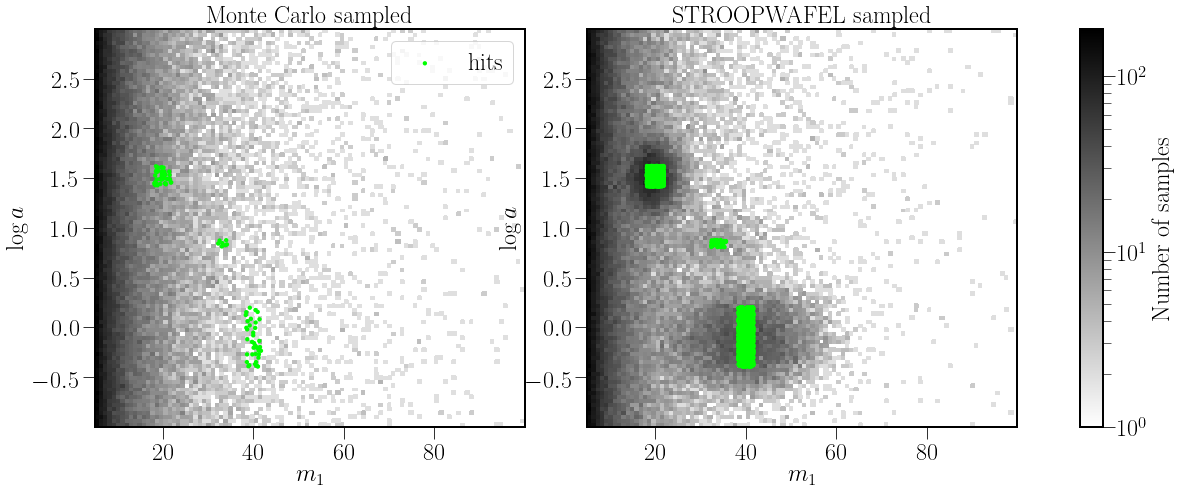

In [6]:
Nbinaries = 100000 

# param_ranges = [[min_m1, max_m1] in  [Msun], [min_loga, max_loga] in [AU], [min_q, max_q]]
# define the parameter range of m1, log(a) and q: (see Appendix C of FSB+2019 for the values)
param_ranges = [[5, 100], [-1, 3], [0, 1]] 

alpha_IMF = 2.3 # kroupa+2001 IMF power law slope value
# obtain the toy model settings for toymodel "m0" (such as the location of the toy model spheres) 
# other options are e.g. modelname = "m1" and "m2"
TM = toymodel(modelname="m0", param_ranges=param_ranges)

# calculate analytically what the fractional volume of the toy model spheres is:
# in practise we don't know on beforehand what this volume is. 
fraction_analytic = TM.analyticalVolume()
print('Analytically determined fractional rate = ', fraction_analytic)
print()


##################################################
#### birth distribution Monte Carlo sampling #####
##################################################

# now run a Traditional Monte Carlo experiment to estimate this rate:
SAMPLING = sampling(Nsamples=Nbinaries, param_ranges=param_ranges, alpha_IMF=alpha_IMF)
samples_MC, mask_hits_MC, weights_MC =  SAMPLING.sampling_MC(modelname='m0')

MonteCarlo_rate_est = np.sum(weights_MC[mask_hits_MC]) / len(samples_MC[0])

print('Traditional Monte Carlo fractional rate estimate = ', MonteCarlo_rate_est, '+/-',\
      np.round(np.sqrt(np.sum(weights_MC[mask_hits_MC])) / len(samples_MC[0]) ,6))
print('Nhits traditional Monte Carlo = ',  len(samples_MC[0][mask_hits_MC]))
print()



##############################
#### STROOPWAFEL sampling ####
##############################

SW = stroopwafel(modelname='m0', Nsamples=Nbinaries, param_ranges=param_ranges, alpha_IMF=alpha_IMF)
samples_SW, mask_hits_SW, weights_SW = SW.stroopwafel(res_sampling=0.01, kappa=2, printing=True)

stroopwafel_rate_est = np.sum(weights_SW[mask_hits_SW]) / len(samples_SW[0])
phi_xw_x = (mask_hits_SW*weights_SW) # phi(x_i)*w_i in Eq. 15 
stroopwafel_uncertainty = np.std(phi_xw_x, ddof=1) / np.sqrt(len(samples_SW[0])) # sqrt of Var[R_T] in Eq. 15

print('stroopwafel rate estimate = ', np.round(stroopwafel_rate_est,7),\
      '+/-', np.round(stroopwafel_uncertainty,6))
print('Nhits stroopwafel = ',  len(samples_SW[0][mask_hits_SW]))
print()

plotSamples(samples_MC=samples_MC, mask_hits_MC=mask_hits_MC, samples_SW=samples_SW, mask_hits_SW=mask_hits_SW)

